# Installation

In order to run Scenic, we had to specify several package versions. This combination made it work for us:

conda create -n pyscenic python==3.10
conda activate pyscenic
pip install pyscenic==0.12.1 numpy==1.23.4 distributed==2024.2.1 dask-expr==0.5.3 ipykernel cmake==3.18.4 MulticoreTSNE

At least for aucell, we need pip install pandas==1.5.3 numba==0.56.4

For plotting, we need pip install igraph leidenalg ipywidgets

# Setup

In [1]:
# Basic packages
import loompy as lp
import scanpy as sc
sc.settings.njobs = 32
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
np.object = object
import anndata as ad

# Pyscenic-related
import pyscenic
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.aucell import aucell
from dask.diagnostics import ProgressBar
from pyscenic.prune import prune2df
from pyscenic.prune import df2regulons

# Plot
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Other
import pickle
import glob
import os
import warnings
warnings.filterwarnings("ignore")

# Modify files

Data were prepared in `Objects_preperations.ipynb`. Motif data were collected from public resources as directed in the pyscenic tutorial. Here, we modify the motif databases to only contain genes in our data as suggested by the authors of pyscenic.

For file download, see:

- https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/
- https://resources.aertslab.org/cistarget/motif2tf/
- https://github.com/aertslab/SCENICprotocol/blob/master/example/allTFs_hg38.txt

In [3]:
adata = ad.read_h5ad("microglia.h5ad")
dff = pd.read_feather("hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dff2 = pd.read_feather("hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dft = pd.read_table("motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl")
tf = pd.read_table("allTFs_hg38.txt", header = None)

In [4]:
dff = dff.loc[:, dff.columns.isin(adata.var.index.append(pd.Index(["motifs"])))]
dff2 = dff2.loc[:, dff2.columns.isin(adata.var.index.append(pd.Index(["motifs"])))]
dft = dft[dft["gene_name"].isin(adata.var.index)]
tf = tf[tf[0].isin(adata.var.index)]
adata = adata[:, adata.var.index.isin(dff2.columns)]
adata

View of AnnData object with n_obs × n_vars = 6076 × 12058
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [5]:
dff.to_feather("modified_micro_hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dff2.to_feather("modified_micro_hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
dft.to_csv("modified_micro_motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl", sep = "\t", index = False)
tf.to_csv("modified_micro_allTFs_hg38.txt", sep = "\t", index = False, header = False)
adata.write_h5ad("modified_microglia.h5ad")

# Create loom file

In [6]:
adata = ad.read_h5ad("modified_microglia.h5ad")
adata

AnnData object with n_obs × n_vars = 6076 × 12058
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [7]:
adata.obs

,annotation,Clusters,_X,_Y,initial_size_unspliced,initial_size_spliced,initial_size
cells,,,,,,,
PD_7044!!ATTCGTTTCAGACTGT-1,Intermediate1,0,28.315714,-3.390749,4120,1018,1018.0
PD_1449!!AACGGGAGTAGCGCCT-1,Intermediate2,4,6.466043,17.918211,939,425,425.0
PD_7731!!ATTCTTGCAGGTATGG-1,Intermediate2,5,14.585819,9.087754,2374,570,570.0
CTRL_09055!!GATTTCTCACATATGC-1,Intermediate2,0,-4.032632,0.349676,994,321,321.0
MSA_1398!!CGCCATTGTTGTATGC-1,Steady-state,4,29.199759,1.157821,2734,403,403.0
...,...,...,...,...,...,...,...
PD_7044!!TTCTTCCCAGCTGGTC-1,Activated,4,-18.652267,26.990530,8513,1749,1749.0
PD_7044!!TGAGGTTCATCTATCT-1,Intermediate1,0,0.657309,13.900185,6591,899,899.0
MSA_1436!!GGCAGTCGTCTCAGGC-1,Intermediate1,1,-8.456874,14.590725,5096,767,767.0


In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['n_genes'] < 4000, :]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 6046 × 12058
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [10]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create("microglia_pvms.loom", adata.X.transpose(), row_attrs, col_attrs)

# Run pyscenic CLI

! GRN inference
pyscenic grn \
/work/msa/02_data/scenic/microglia_pvms.loom \
/work/msa/02_data/scenic/modified_micro_allTFs_hg38.txt \
-o /work/msa/02_data/scenic/microglia_pvms_adj.csv \
-m grnboost2 \
--num_workers 64

! Regulon prediction
pyscenic ctx \
/work/msa/02_data/scenic/microglia_pvms_adj.csv \
/work/msa/02_data/scenic/modified_micro_hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather /work/msa/02_data/scenic/modified_micro_hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
--annotations_fname /work/msa/02_data/scenic/modified_micro_motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
--expression_mtx_fname /work/msa/02_data/scenic/microglia_pvms.loom \
--output /work/msa/02_data/scenic/microglia_pvms_reg.csv \
--mask_dropouts \
--num_workers 64

In [18]:
# Check auc_threshold, default it 0.05
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = pd.DataFrame(nGenesDetectedPerCell).quantile([.01, .05, .10, .15, .50, 1])
print(percentiles)

            0
0.01   903.65
0.05  1135.75
0.10  1284.50
0.15  1400.00
0.50  2081.00
1.00  3998.00


pyscenic aucell \
/work/msa/02_data/scenic/microglia_pvms.loom \
/work/msa/02_data/scenic/microglia_pvms_reg.csv \
--output /work/msa/02_data/scenic/microglia_pvms_results.loom \
--num_workers 64

# Downstream analyses for all cells

## Setup

::: MulticoreTSNE induces error for binarization, so run tSNE BEFORE switching to pyscenic2 which doesn't contain this app :::

conda create -y -n pyscenic2 python==3.10 pip install pyscenic==0.12.1 numpy==1.23.4 distributed==2024.2.1 dask-expr==0.5.3 ipykernel cmake==3.18.4 igraph leidenalg ipywidgets anndata matplotlib seaborn scanpy adjustText

In [10]:
# ---
# Change to pyscenic2 virtual environment
# ---

import loompy as lp
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
sc.settings.njobs = 32
import seaborn as sns
np.object = object

from pyscenic.rss import regulon_specificity_scores
from pyscenic.binarization import binarize

# Plot
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from pyscenic.plotting import plot_rss
from adjustText import adjust_text
import matplotlib as mpl

# Other
import operator as op
import warnings
warnings.filterwarnings("ignore")

## Generate UMAP and tSNE based on the AUC matrix

In [2]:
lf = lp.connect("microglia_pvms_results.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

auc_mtx

,ARID3A(+),ARNT(+),ARNTL(+),ATF1(+),ATF3(+),ATF4(+),ATF6B(+),ATF7(+),BACH1(+),BACH2(+),...,ZNF805(+),ZNF846(+),ZNF85(+),ZNF91(+),ZSCAN20(+),ZSCAN21(+),ZSCAN29(+),ZSCAN30(+),ZSCAN31(+),ZSCAN5A(+)
PD_7044!!ATTCGTTTCAGACTGT-1,0.005547,0.032437,0.0000,0.0,0.023903,0.0,0.000000,0.042240,0.358209,0.006485,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
PD_1449!!AACGGGAGTAGCGCCT-1,0.006900,0.032939,0.0000,0.0,0.015327,0.0,0.038327,0.000000,0.177446,0.026707,...,0.042974,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
PD_7731!!ATTCTTGCAGGTATGG-1,0.006805,0.038203,0.0000,0.0,0.033031,0.0,0.000000,0.010048,0.212272,0.027945,...,0.041459,0.0,0.000000,0.011332,0.0,0.0,0.000000,0.0,0.034826,0.0
CTRL_09055!!GATTTCTCACATATGC-1,0.007892,0.015732,0.0236,0.0,0.024269,0.0,0.000000,0.015706,0.176119,0.015297,...,0.000000,0.0,0.032019,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
MSA_1398!!CGCCATTGTTGTATGC-1,0.016908,0.028192,0.0000,0.0,0.036057,0.0,0.000000,0.024485,0.162189,0.042177,...,0.002524,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.050415,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PD_7044!!TTCTTCCCAGCTGGTC-1,0.013953,0.019322,0.0000,0.0,0.017987,0.0,0.000000,0.035460,0.366501,0.007153,...,0.042685,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
PD_7044!!TGAGGTTCATCTATCT-1,0.001639,0.017147,0.0000,0.0,0.025044,0.0,0.000000,0.028875,0.367164,0.027450,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
MSA_1436!!GGCAGTCGTCTCAGGC-1,0.000000,0.029470,0.0000,0.0,0.024649,0.0,0.000000,0.000000,0.092206,0.037202,...,0.025597,0.0,0.000000,0.000000,0.0,0.0,0.004656,0.0,0.000000,0.0
PD_8095!!TGTTCCGCATAATGAG-1,0.006958,0.029379,0.0000,0.0,0.027194,0.0,0.057306,0.027851,0.191045,0.042053,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


In [3]:
import umap
# UMAP
runUmap = umap.UMAP(n_neighbors=15, min_dist=0.4, metric='correlation', n_jobs = 60, low_memory=False, verbose = True).fit_transform
dr_umap = runUmap(auc_mtx)
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).reset_index().to_feather( "microglia_pvms_umap.feather")

UMAP(angular_rp_forest=True, low_memory=False, metric='correlation', min_dist=0.4, n_jobs=60, verbose=True)
Fri Jun 28 11:29:58 2024 Construct fuzzy simplicial set
Fri Jun 28 11:29:58 2024 Finding Nearest Neighbors
Fri Jun 28 11:29:58 2024 Building RP forest with 9 trees
Fri Jun 28 11:30:02 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	Stopping threshold met -- exiting after 7 iterations
Fri Jun 28 11:30:13 2024 Finished Nearest Neighbor Search
Fri Jun 28 11:30:15 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Jun 28 11:30:25 2024 Finished embedding


In [4]:
# tSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=64)
dr_tsne = tsne.fit_transform(auc_mtx)
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).reset_index().to_feather( "microglia_pvms_tsne.feather")

## pySCENIC UMAP

In [3]:
dr_umap = pd.read_feather("microglia_pvms_umap.feather")
dr_umap = dr_umap.set_index(dr_umap["index"])[["X","Y"]]

adata = ad.read_h5ad("modified_microglia.h5ad")
cell_list = list(set(adata.obs.index.to_list()) & set(dr_umap.index.to_list()))
adata = adata[cell_list, :]

adata.obsm['X_scenic'] = np.array(dr_umap.reindex(adata.obs.index))

sc.pp.neighbors(adata, n_neighbors=15, use_rep = 'X_scenic')
sc.tl.leiden(adata, resolution=0.05)

adata

AnnData object with n_obs × n_vars = 6046 × 12058
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors', 'leiden'
    obsm: 'X_umap', 'X_scenic'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

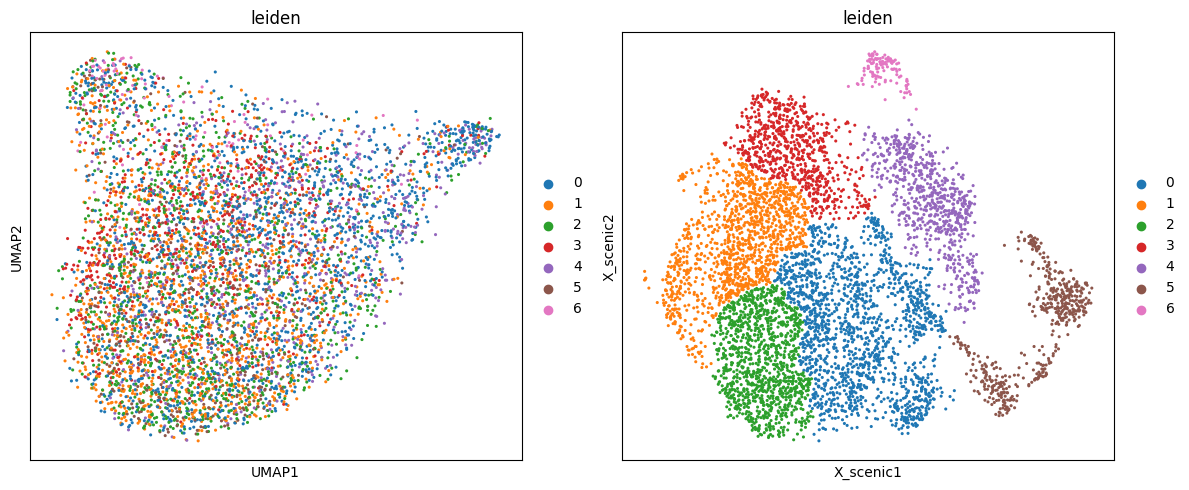

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['leiden'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['leiden'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

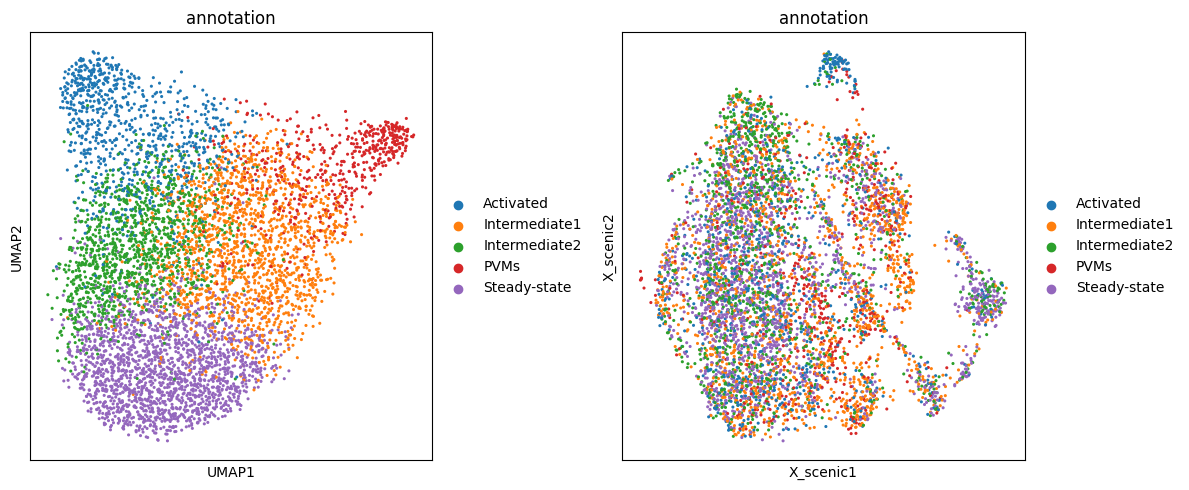

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['annotation'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['annotation'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

## pySCENIC tSNE

In [6]:
dr_tsne = pd.read_feather("microglia_pvms_tsne.feather")
dr_tsne = dr_tsne.set_index(dr_tsne["index"])[["X","Y"]]

adata = ad.read_h5ad("modified_microglia.h5ad")
cell_list = list(set(adata.obs.index.to_list()) & set(dr_tsne.index.to_list()))
adata = adata[cell_list, :]

adata.obsm['X_scenic'] = np.array(dr_tsne.reindex(adata.obs.index))

sc.pp.neighbors(adata, n_neighbors=15, use_rep = 'X_scenic')
sc.tl.leiden(adata, resolution=0.05)

adata

AnnData object with n_obs × n_vars = 6046 × 12058
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors', 'leiden'
    obsm: 'X_umap', 'X_scenic'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

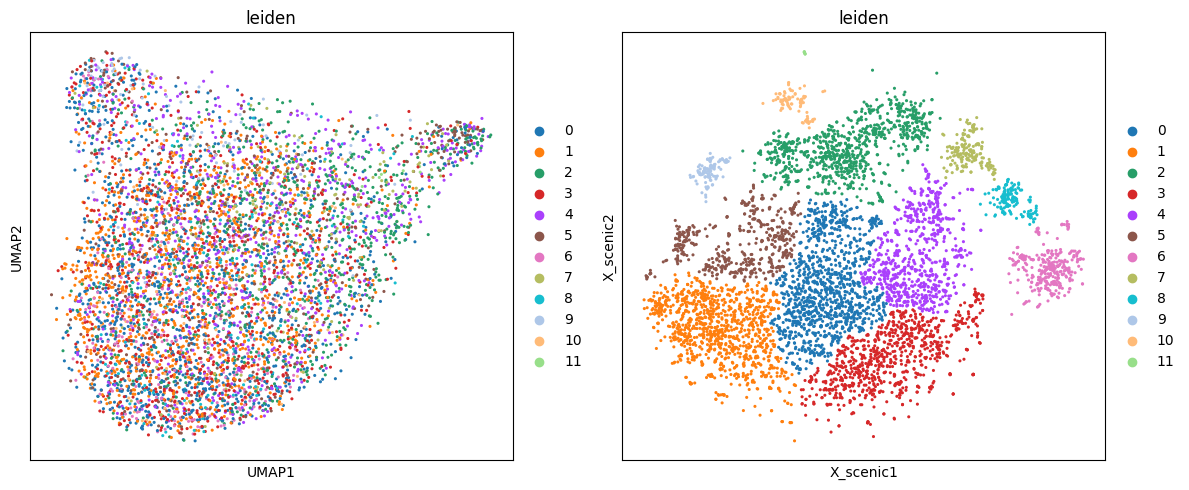

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['leiden'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['leiden'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

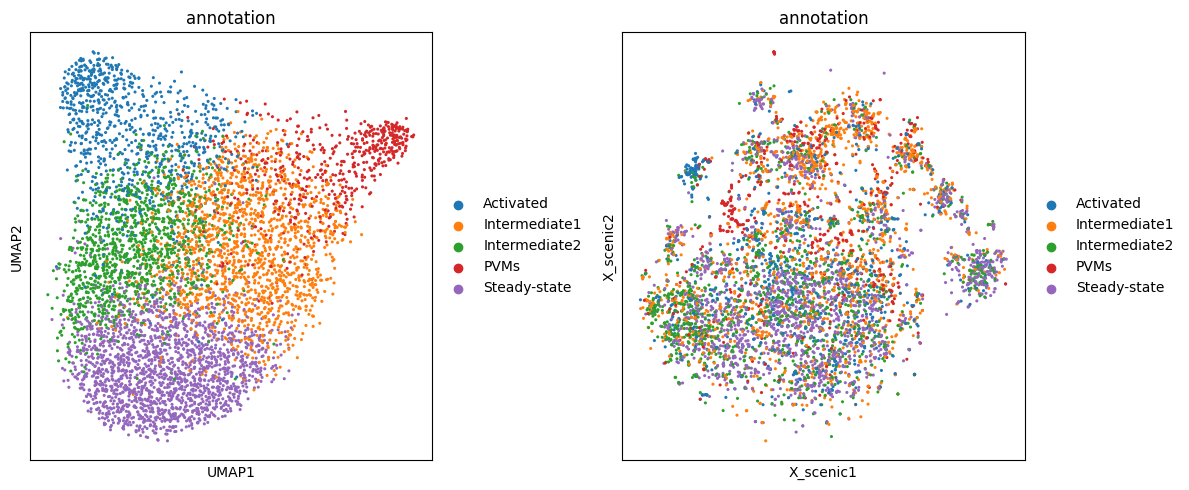

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
p1 = sc.pl.umap(adata, color = ['annotation'], ax = ax1, show = False)
p2 = sc.pl.embedding(adata, 'X_scenic', color = ['annotation'], ax = ax2, show = False)
plt.tight_layout()
plt.show()

## Convert AUCscore to z-score 

In [2]:
lf = lp.connect("microglia_pvms_results.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

adata = ad.read_h5ad("modified_microglia.h5ad")

In [3]:
adata.obs

,annotation,Clusters,_X,_Y,initial_size_unspliced,initial_size_spliced,initial_size
cells,,,,,,,
PD_7044!!ATTCGTTTCAGACTGT-1,Intermediate1,0,28.315714,-3.390749,4120,1018,1018.0
PD_1449!!AACGGGAGTAGCGCCT-1,Intermediate2,4,6.466043,17.918211,939,425,425.0
PD_7731!!ATTCTTGCAGGTATGG-1,Intermediate2,5,14.585819,9.087754,2374,570,570.0
CTRL_09055!!GATTTCTCACATATGC-1,Intermediate2,0,-4.032632,0.349676,994,321,321.0
MSA_1398!!CGCCATTGTTGTATGC-1,Steady-state,4,29.199759,1.157821,2734,403,403.0
...,...,...,...,...,...,...,...
PD_7044!!TTCTTCCCAGCTGGTC-1,Activated,4,-18.652267,26.990530,8513,1749,1749.0
PD_7044!!TGAGGTTCATCTATCT-1,Intermediate1,0,0.657309,13.900185,6591,899,899.0
MSA_1436!!GGCAGTCGTCTCAGGC-1,Intermediate1,1,-8.456874,14.590725,5096,767,767.0


In [4]:
new_idx = []
for string in adata.obs.index:
    new_idx.append(string.split(sep = "_", maxsplit = 1)[0])

adata.obs["visit"] = pd.Categorical(new_idx)
adata.obs

,annotation,Clusters,_X,_Y,initial_size_unspliced,initial_size_spliced,initial_size,visit
cells,,,,,,,,
PD_7044!!ATTCGTTTCAGACTGT-1,Intermediate1,0,28.315714,-3.390749,4120,1018,1018.0,PD
PD_1449!!AACGGGAGTAGCGCCT-1,Intermediate2,4,6.466043,17.918211,939,425,425.0,PD
PD_7731!!ATTCTTGCAGGTATGG-1,Intermediate2,5,14.585819,9.087754,2374,570,570.0,PD
CTRL_09055!!GATTTCTCACATATGC-1,Intermediate2,0,-4.032632,0.349676,994,321,321.0,CTRL
MSA_1398!!CGCCATTGTTGTATGC-1,Steady-state,4,29.199759,1.157821,2734,403,403.0,MSA
...,...,...,...,...,...,...,...,...
PD_7044!!TTCTTCCCAGCTGGTC-1,Activated,4,-18.652267,26.990530,8513,1749,1749.0,PD
PD_7044!!TGAGGTTCATCTATCT-1,Intermediate1,0,0.657309,13.900185,6591,899,899.0,PD
MSA_1436!!GGCAGTCGTCTCAGGC-1,Intermediate1,1,-8.456874,14.590725,5096,767,767.0,MSA


In [5]:
anno_vis = []
for anno, vis in zip(adata.obs["annotation"], adata.obs["visit"]):
    anno_vis.append("_".join([anno,vis]))

anno_vis = pd.Categorical(anno_vis).reorder_categories(['Steady-state_CTRL', 'Steady-state_MSA', 'Steady-state_PD',
                                                        'Intermediate1_CTRL', 'Intermediate1_MSA', 'Intermediate1_PD', 
                                                        'Intermediate2_CTRL', 'Intermediate2_MSA', 'Intermediate2_PD', 
                                                        'Activated_CTRL', 'Activated_MSA', 'Activated_PD', 
                                                        'PVMs_CTRL', 'PVMs_MSA', 'PVMs_PD'])
adata.obs["anno_vis"] = anno_vis
adata.obs

,annotation,Clusters,_X,_Y,initial_size_unspliced,initial_size_spliced,initial_size,visit,anno_vis
cells,,,,,,,,,
PD_7044!!ATTCGTTTCAGACTGT-1,Intermediate1,0,28.315714,-3.390749,4120,1018,1018.0,PD,Intermediate1_PD
PD_1449!!AACGGGAGTAGCGCCT-1,Intermediate2,4,6.466043,17.918211,939,425,425.0,PD,Intermediate2_PD
PD_7731!!ATTCTTGCAGGTATGG-1,Intermediate2,5,14.585819,9.087754,2374,570,570.0,PD,Intermediate2_PD
CTRL_09055!!GATTTCTCACATATGC-1,Intermediate2,0,-4.032632,0.349676,994,321,321.0,CTRL,Intermediate2_CTRL
MSA_1398!!CGCCATTGTTGTATGC-1,Steady-state,4,29.199759,1.157821,2734,403,403.0,MSA,Steady-state_MSA
...,...,...,...,...,...,...,...,...,...
PD_7044!!TTCTTCCCAGCTGGTC-1,Activated,4,-18.652267,26.990530,8513,1749,1749.0,PD,Activated_PD
PD_7044!!TGAGGTTCATCTATCT-1,Intermediate1,0,0.657309,13.900185,6591,899,899.0,PD,Intermediate1_PD
MSA_1436!!GGCAGTCGTCTCAGGC-1,Intermediate1,1,-8.456874,14.590725,5096,767,767.0,MSA,Intermediate1_MSA


In [6]:
cell_list = list(set(adata.obs.index.to_list()) & set(auc_mtx.index.to_list()))
adata = adata[cell_list, :]
adata

View of AnnData object with n_obs × n_vars = 6046 × 12058
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'visit', 'anno_vis'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [8]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

auc_mat = ad.AnnData(X = auc_mtx_Z)
auc_mat.obs["anno_vis"] = adata.obs["anno_vis"]

auc_mtx_Z["anno_vis"] = adata.obs["anno_vis"]

mean_auc_by_cell_type = auc_mtx_Z.groupby("anno_vis").mean()

top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

## Dotplot

Here, we select some of the most interesting regulons and divide them into two plots, one more specific for PVMs, one more specific for MSA in general

In [55]:
regulons = list(top_tfs.index.to_list()[i] for i in [1,4,5,6,7,11,14,15,16,17,18,19,20,21,22,23,26,27,28,31,32,33,35,36,37,38,39,41,42,46,47])
regulons

['TCF4(+)',
 'NR3C1(+)',
 'FOSL2(+)',
 'STAT1(+)',
 'ILF2(+)',
 'ETV7(+)',
 'DRAP1(+)',
 'ELF1(+)',
 'ZNF552(+)',
 'CREM(+)',
 'NFKB1(+)',
 'STAT2(+)',
 'ELF2(+)',
 'MITF(+)',
 'CHD1(+)',
 'GATAD1(+)',
 'FOXO3(+)',
 'NFE2L2(+)',
 'NR1D2(+)',
 'MXD4(+)',
 'LCORL(+)',
 'ZNF621(+)',
 'HIF1A(+)',
 'IRF1(+)',
 'SREBF1(+)',
 'RXRA(+)',
 'BCL11A(+)',
 'IKZF1(+)',
 'MYBL1(+)',
 'CEBPA(+)',
 'TFEC(+)']

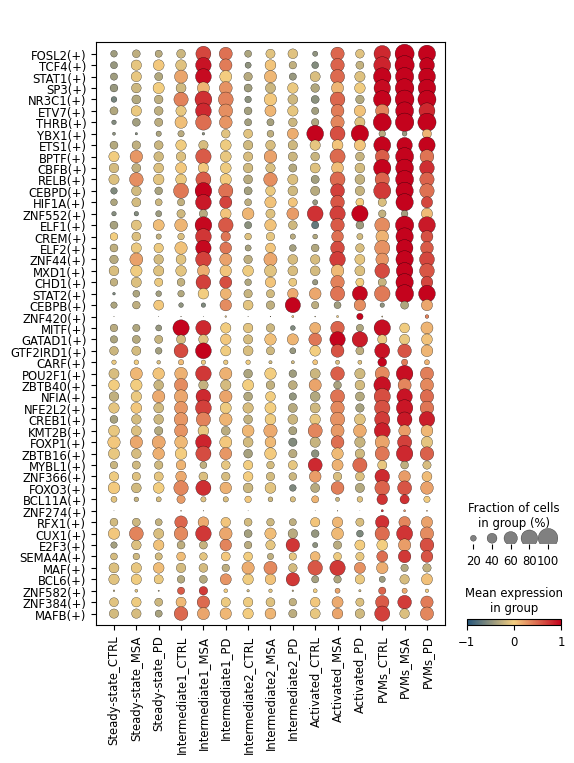

<Figure size 640x480 with 0 Axes>

In [17]:
cmap = LinearSegmentedColormap.from_list('sweet', ['#25557B', '#F4CE80', '#C4031D'])

regulons = top_tfs.index.to_list()

fig, (ax1) = plt.subplots(1,1, figsize=(6,8))
sc.pl.dotplot(auc_mat, regulons, groupby='anno_vis', cmap=cmap, vmin=-1, vmax=1, vcenter=0, swap_axes=True, ax=ax1, categories_order = auc_mat.obs["anno_vis"].cat.categories)
plt.tight_layout()

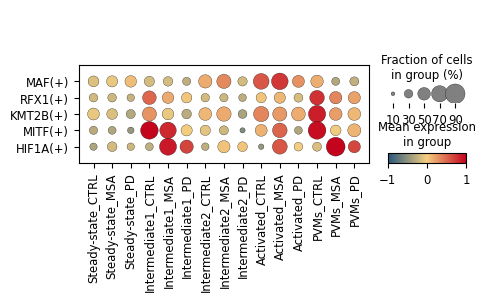

In [13]:
# PVM interesting regulons

cmap = LinearSegmentedColormap.from_list('sweet', ['#25557B', '#F4CE80', '#C4031D'])

regulons = [gene + "(+)" for gene in ["MAF", "RFX1", "KMT2B", "MITF", "HIF1A"]]

fig, (ax1) = plt.subplots(1,1, figsize=(5,2))
sc.pl.dotplot(auc_mat, regulons, groupby='anno_vis', cmap=cmap, vmin=-1, vmax=1, vcenter=0, swap_axes=True, ax=ax1, categories_order = auc_mat.obs["anno_vis"].cat.categories)

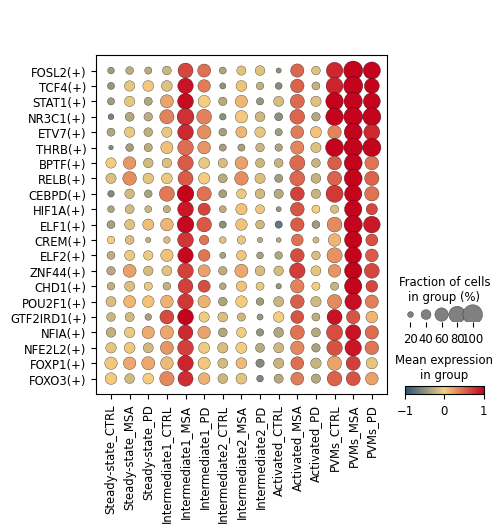

<Figure size 640x480 with 0 Axes>

In [14]:
# PVM interesting regulons

cmap = LinearSegmentedColormap.from_list('sweet', ['#25557B', '#F4CE80', '#C4031D'])

regulons = [gene + "(+)" for gene in ["FOSL2", "TCF4", "STAT1", "NR3C1", "ETV7", "THRB", "BPTF", "RELB", "CEBPD", "HIF1A", "ELF1", "CREM", "ELF2", 
                                      "ZNF44", "CHD1", "POU2F1", "GTF2IRD1", "NFIA", "NFE2L2", "FOXP1", "FOXO3"]]

fig, (ax1) = plt.subplots(1,1, figsize=(5,5))
sc.pl.dotplot(auc_mat, regulons, groupby='anno_vis', cmap=cmap, vmin=-1, vmax=1, vcenter=0, swap_axes=True, ax=ax1, categories_order = auc_mat.obs["anno_vis"].cat.categories)
plt.tight_layout()